<h1> Cat and Dog Classification </h1>

Author: Vaasudevan Srinivasan <br>
Created on: July 26, 2021

[Reference](https://www.tensorflow.org/tutorials/images/transfer_learning)

In [ ]:
%%capture

!wget -nc 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
!unzip -o cats_and_dogs_filtered.zip

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# Preprocessing

In [ ]:
train_dir = 'cats_and_dogs_filtered/train'
validation_dir = 'cats_and_dogs_filtered/validation'
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


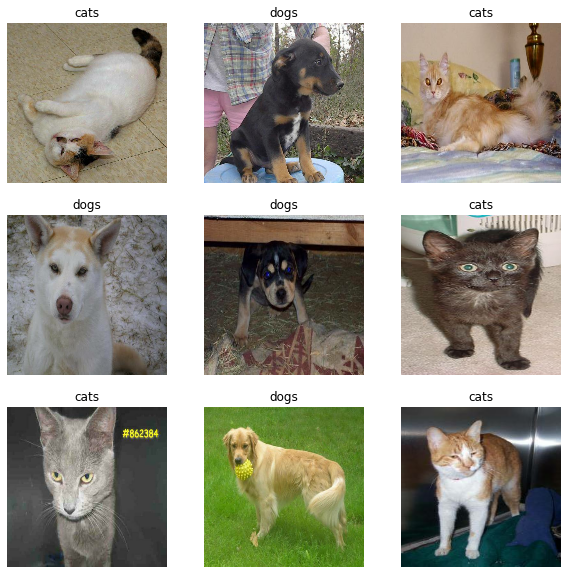

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [ ]:
# Split test dataset from validation data

val_batches = tf.data.experimental.cardinality(validation_dataset)
print(tf.data.experimental.cardinality(validation_dataset))

test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print(tf.data.experimental.cardinality(validation_dataset))
print(tf.data.experimental.cardinality(test_dataset))

tf.Tensor(32, shape=(), dtype=int64)
tf.Tensor(26, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)


# Performance Improvement

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Augmentation and Model

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


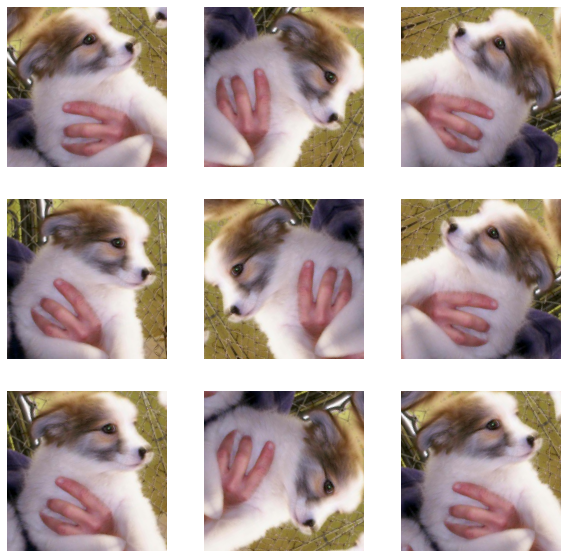

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
IMG_SHAPE

(160, 160, 3)

In [ ]:
base_model.trainable = False

# Global Average Pooling

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 5, 5, 1280)
(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0     

In [ ]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[ 0.05515039],
        [ 0.04827724],
        [ 0.05325492],
        ...,
        [ 0.02545565],
        [-0.03898048],
        [ 0.03437559]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 94ms/step - loss: 0.6888 - accuracy: 0.5735 - val_loss: 0.4992 - val_accuracy: 0.6980
Epoch 2/10
63/63 [==============================] - 6s 88ms/step - loss: 0.5196 - accuracy: 0.7120 - val_loss: 0.3649 - val_accuracy: 0.8119
Epoch 3/10
63/63 [==============================] - 5s 68ms/step - loss: 0.4224 - accuracy: 0.7830 - val_loss: 0.2831 - val_accuracy: 0.8589
Epoch 4/10
63/63 [==============================] - 5s 69ms/step - loss: 0.3381 - accuracy: 0.8430 - val_loss: 0.2376 - val_accuracy: 0.9121
Epoch 5/10
63/63 [==============================] - 5s 69ms/step - loss: 0.2952 - accuracy: 0.8805 - val_loss: 0.1965 - val_accuracy: 0.9307
Epoch 6/10
63/63 [==============================] - 4s 68ms/step - loss: 0.2803 - accuracy: 0.8810 - val_loss: 0.1720 - val_accuracy: 0.9381
Epoch 7/10
63/63 [==============================] - 5s 69ms/step - loss: 0.2613 - accuracy: 0.8875 - val_loss: 0.1575 - val_accuracy: 0.9394
Epoch 8/10
63

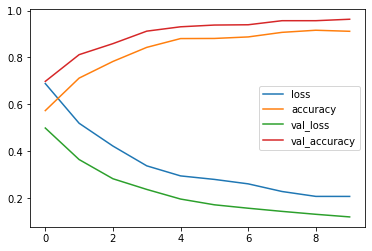

In [ ]:
pd.DataFrame(history.history).plot();